Calibrate the TFR by fitting both galaxies in the Coma cluster and those used for 0-pt calibration simultaneously, weighting the galaxies by 1/$V_{max}$.

In this notebook, we recompute $V_0$ with each recalibration (removing the "dwarf" galaxies - those below the line perpendicular to the current calibration that intersects the calibration at $M_r = -17$).

**Note**: This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table, unique, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy import units as u
from astropy import constants as const
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

import os

import requests

import corner

import pickle

import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from help_functions import adjust_lightness
from line_fits import param_invert, hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# V0 is set to be the median value of all data used in the calibration

# Data

## fuji

In [3]:
# tfuji_all = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot.fits')
tfuji_all = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
# tfuji_all = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji = unique(tfuji_all)
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
-810643058,172.649268761659,50.9379496804841,5615,sv2,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv2/bright/56/5615/redrock-sv2-bright-5615.fits,TFT,632436,172.64931872904359,50.93778398770638
-810083058,172.649268761659,50.9379496804841,5615,sv2,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv2/dark/56/5615/redrock-sv2-dark-5615.fits,TFT,632436,172.64931872904359,50.93778398770638
-4601510,213.789117851594,51.6121621066111,10741,sv3,0.614440857644474,2.5334368384479e-05,2053,4.58016765117645,fuji/healpix/sv3/dark/107/10741/redrock-sv3-dark-10741.fits,TFT,742370,213.78934983594,51.61232801047766
-3809215,253.122574403111,33.7190699815035,9340,sv3,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv3/dark/93/9340/redrock-sv3-dark-9340.fits,TFT,276273,253.12281332574227,33.719157220176115
-2126206,218.818747743752,35.1134907925663,10517,sv3,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv3/backup/105/10517/redrock-sv3-backup-10517.fits,TFT,1362315,218.81857534717938,35.11350628239651


In [4]:
# tfuji[tfuji['SGA_ID'] == 8032]

## SGA

Read in our version of the SGA that includes distances from the Extragalactic Distance Database.  (This file was made with the `data_match.ipynb` notebook.)

In [5]:
# SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
#SGA = Table.read('/Users/kellydouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')
SGA = Table.read('../SGA_distances.fits')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,SN,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,bytes21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25
5002480,SGA-2020 5002480,DR8-2837p402-5033,-1,283.619631436471,40.3162008554537,DEV,178.80934,0.54342,0.3166,-1.0,24.29036,16.9862,False,DR8,530781,DR8-2837p402-5033,1,True,283.619631436471,40.3162008554537,0.54342,2837p402,283.6196056669463,40.316337272867564,0.53864765,SB26,179.53694,0.3690244,283.6194583471782,40.31653379127378,11.641381,11.157478,8.614751,9.8993,1.6142721,3.685578,5.5844307,7.701021,9.878292,11.927793,13.400182,14.697571,16.15943,21.37251,20.373438,19.779512,19.920574,19.005274,18.41066,19.314016,18.435898,17.843414,18.922651,18.076838,17.494484,18.664383,17.833265,17.25879,18.496494,17.682926,17.106598,18.404135,17.605488,17.02742,18.332602,17.555883,16.971588,18.299273,17.52499,16.931496,0.04933311,0.065890566,0.09742977,0.10495926,0.1614855,0.27832195,0.15179653,0.13904023,0.20484819,0.041657884,0.06669066,0.06785251,0.038538612,0.049561314,0.05101378,0.03635901,0.041818976,0.042013034,0.03367074,0.03763669,0.03705858,0.03122176,0.03420294,0.033616345,0.029198052,0.031941395,0.031132452,0.028080799,0.030865192,0.029955743,0.02722575,0.030135926,0.029090546,0.026788738,0.02959205,0.028436601,17.799881,1.3952494,

In [6]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the fuji data into center and off-center observations

In [7]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [8]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [9]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

In [10]:
# 8032 in good_centers['SGA_ID']

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [11]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

### Compute the maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be lcoated to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [12]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [13]:
dist = Distance(z=np.abs(SGA['Z_DESI']), cosmology=Planck18_h)

SGA['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*SGA['D26']*u.arcmin)

SGA['DIST_MAX'] = 0.5*SGA['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.2, cosmology=Planck18_h)

SGA['MAX_VOL_FRAC'] = SGA['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [14]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [15]:
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigP'][Coma_row_t3][0]
mu_Coma = table3['DM'][Coma_row_t3][0]

Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic')

In [16]:
d_Coma = 10*10**(0.2*mu_Coma) # pc
V_Coma = 100*(d_Coma*1e-6) # km/s

V_Coma

7345.138681571143

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [17]:
# First, we need to convert R2t from Mpc to an angle, using the group's velocity
# Note that we are NOT assuming that the size of the cluster is a small angle!!
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(d_Coma*1e-6))*u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(d_Coma*1e-6))*u.radian

In [18]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [19]:
SGA_in_Coma1 = (sep < R2t_Coma_angle_1p5) & (SGA['Z_DESI']*c.value > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c.value < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= R2t_Coma_angle_1p5) & (sep < R2t_Coma_angle_3) & (SGA['Z_DESI']*c.value > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c.value < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
print('fuji off-center observations in Coma:', len(axis_inComa))

fuji galaxies in Coma with good center observations: 275
fuji off-center observations in Coma: 909


In [20]:
# 8032 in SGA_ID_in_Coma

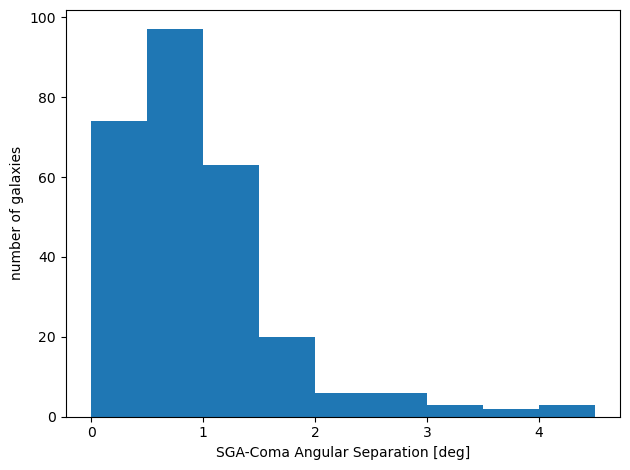

In [21]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

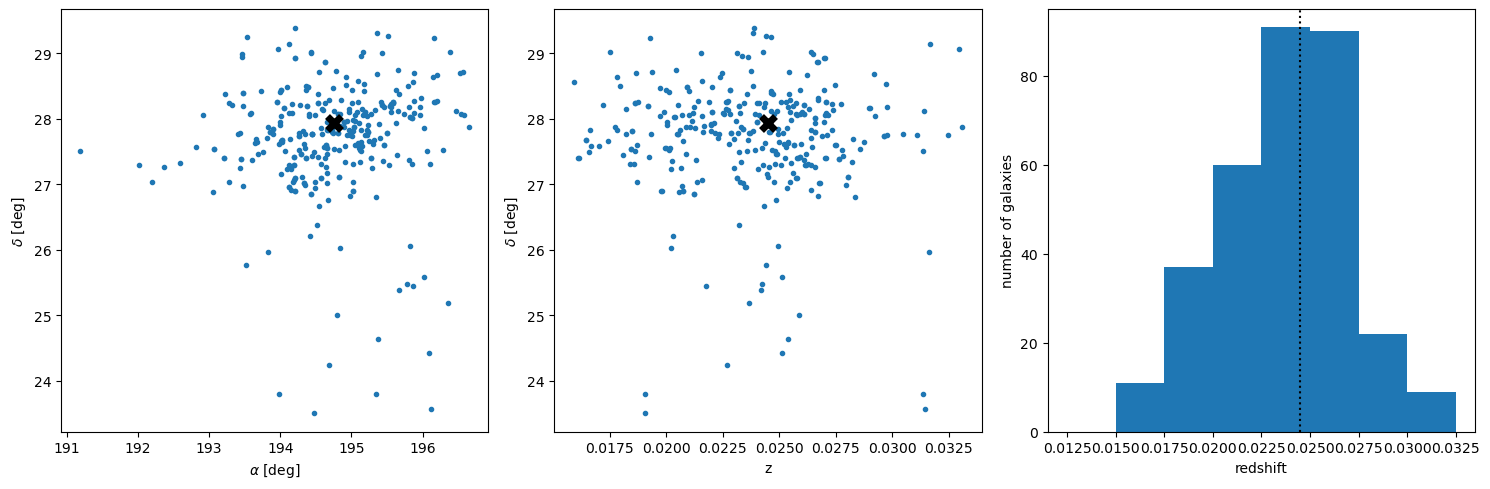

In [22]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(V_Coma/c.value, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c.value, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=95);

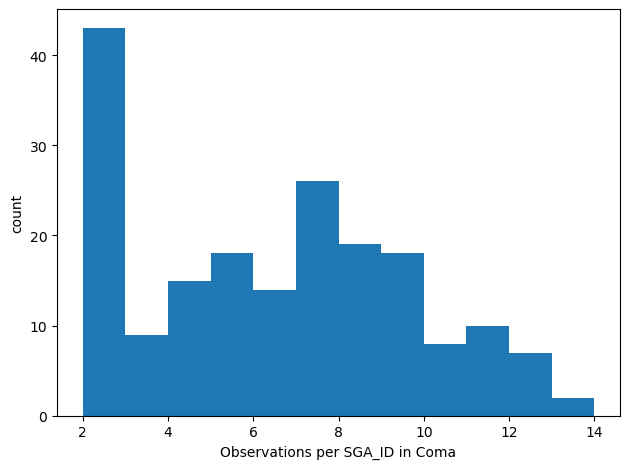

In [23]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# 0-pt calibrators

Which objects with center observations also have independent distances?

In [24]:
distances = (SGA['DM_Stellar'] != -1) | (SGA['DM1_SN'] != -1) #| np.isfinite(SGA['DM_PantheonSH0ES'])
centers = np.isfinite(SGA['Z_DESI'])

################################################################################
# Keep all observations of each galaxy that have independent distances
#-------------------------------------------------------------------------------
SGA_ID_dist = SGA['SGA_ID'][distances & centers]

centers_dist = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_dist)]

axis_dist = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_dist)]
################################################################################

print('fuji galaxies with distances and good center observations:', len(np.unique(centers_dist['SGA_ID'])))
print('fuji off-center observations in galaxies with distances:', len(axis_dist))

fuji galaxies with distances and good center observations: 11
fuji off-center observations in galaxies with distances: 25


# Calculate the rotational velocity

## For Coma galaxies

In [25]:
axis_inComa['SKY_FIBER_DIST'] = 0.
axis_inComa['SKY_FIBER_DIST_R26'] = 0.
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_inComa['RA'][obs_idx], 
                             dec=axis_inComa['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_inComa['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_inComa['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    # axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    # axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center2)
    z_rot = (1 + axis_inComa['Z'][obs_idx])/(1 + z_center) - 1
    axis_inComa['V_ROT'][obs_idx] = c*z_rot
    axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_inComa['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center2*((1 + axis_inComa['Z'][obs_idx])/(1 + z_center)**2))
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

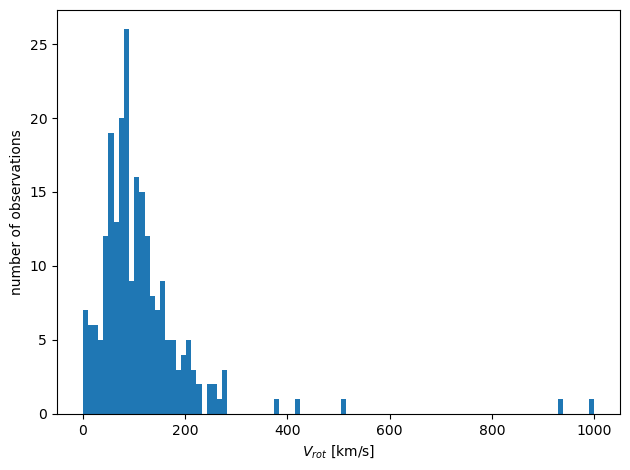

In [26]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

## For 0-pt calibrators

In [27]:
axis_dist['SKY_FIBER_DIST'] = 0.
axis_dist['SKY_FIBER_DIST_R26'] = 0.
axis_dist['V_ROT'] = np.nan
axis_dist['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_dist['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis_dist['RA'][obs_idx], 
                             dec=axis_dist['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis_dist['SKY_FIBER_DIST'][obs_idx] = sep2d
    axis_dist['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    # axis_dist['V_ROT'][obs_idx] = c*(axis_dist['Z'][obs_idx] - z_center)
    # axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_dist['ZERR'][obs_idx]**2 + z_err_center2)
    z_rot = (1 + axis_dist['Z'][obs_idx])/(1 + z_center) - 1
    axis_dist['V_ROT'][obs_idx] = c*z_rot
    axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_dist['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center2*((1 + axis_dist['Z'][obs_idx])/(1 + z_center)**2))
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_dist['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

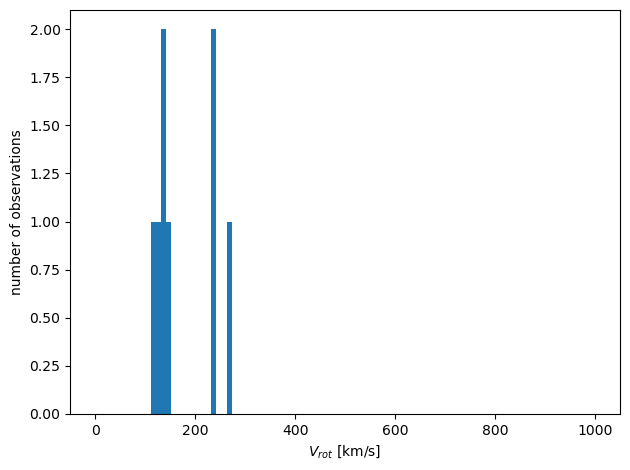

In [28]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_dist['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

## Velocity cut

In [29]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_inComa['V_ROT']) < 1000) & (np.abs(axis_inComa['V_ROT']) > 10)

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

193 113


In [30]:
# 8032 in good_axis_inComa['SGA_ID']

In [31]:
r0p3_0pt = (axis_dist['SKY_FIBER_DIST_R26'] > 0.3) & (axis_dist['SKY_FIBER_DIST_R26'] < 0.4)

Vgood_0pt = (np.abs(axis_dist['V_ROT']) < 1000) & (np.abs(axis_dist['V_ROT']) > 10)

good_axis_dist = axis_dist[r0p3_0pt & Vgood_0pt]

print(len(good_axis_dist), len(np.unique(good_axis_dist['SGA_ID'])))

7 3


## Relative velocity cut

In [32]:
good_deltaV = np.ones(len(good_axis_inComa), dtype=bool)

for sga_id in np.unique(good_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_inComa['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_inComa['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [33]:
good_deltaV_axis_inComa = good_axis_inComa[good_deltaV]

print(len(good_deltaV_axis_inComa), len(np.unique(good_deltaV_axis_inComa['SGA_ID'])))

185 110


In [34]:
# 8032 in good_deltaV_axis_inComa['SGA_ID']

In [35]:
good_deltaV_0pt = np.ones(len(good_axis_dist), dtype=bool)

for sga_id in np.unique(good_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_dist['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_dist['DELTACHI2'] >= 25
            
            good_deltaV_0pt[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_dist['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV_0pt[good_obs_idx] = False

In [36]:
good_deltaV_axis_dist = good_axis_dist[good_deltaV_0pt]

print(len(good_deltaV_axis_dist), len(np.unique(good_deltaV_axis_dist['SGA_ID'])))

7 3


## Inclination angle cut

In [37]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

i_min = 45. # degrees
cosi2_max = np.cos(i_min*np.pi/180.)**2

In [38]:
good_deltaV_axis_inComa['iSGA'] = -1

for i in range(len(good_deltaV_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_inComa['SGA_ID'][i]]
    
    good_deltaV_axis_inComa['iSGA'][i] = sga_idx
    
good_deltaV_axis_inComa['cosi2'] = SGA['cosi2'][good_deltaV_axis_inComa['iSGA']]

In [39]:
edge = good_deltaV_axis_inComa['cosi2'] <= cosi2_max

good_edge_axis_inComa = good_deltaV_axis_inComa[edge]

print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))

150 91


In [40]:
# 8032 in good_edge_axis_inComa['SGA_ID']

In [41]:
good_deltaV_axis_dist['iSGA'] = -1

for i in range(len(good_deltaV_axis_dist)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_dist['SGA_ID'][i]]
    
    good_deltaV_axis_dist['iSGA'][i] = sga_idx
    
good_deltaV_axis_dist['cosi2'] = SGA['cosi2'][good_deltaV_axis_dist['iSGA']]

In [42]:
edge_0pt = good_deltaV_axis_dist['cosi2'] <= cosi2_max

good_edge_axis_dist = good_deltaV_axis_dist[edge_0pt]

print(len(good_edge_axis_dist), len(np.unique(good_edge_axis_dist['SGA_ID'])))

6 2


## Morphology cut

In [43]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [44]:
# good_edge_axis_inComa['MORPHTYPE'][good_edge_axis_inComa['SGA_ID'] == 8032]

In [45]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa), len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
--
--
80 45


In [46]:
good_edge_axis_dist['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_dist['iSGA']]

In [47]:
spirals_0pt = np.zeros(len(good_edge_axis_dist), dtype=bool)

for i in range(len(good_edge_axis_dist)):
    
    try:    
        if (good_edge_axis_dist['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_dist['MORPHTYPE'][i][:2] != 'S0'):
            spirals_0pt[i] = True
        elif good_edge_axis_dist['MORPHTYPE'][i] == 'N/A':
            spirals_0pt[i] = True
    except IndexError:
        print(good_edge_axis_dist['MORPHTYPE'][i])

good_edge_spirals_axis_dist = good_edge_axis_dist[spirals_0pt]

print(len(good_edge_spirals_axis_dist), len(np.unique(good_edge_spirals_axis_dist['SGA_ID'])))

6 2


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [39]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [40]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    '''
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break
    ''';

cache/coma_39628443968603627.jpg exists.
cache/coma_39628438620866050.jpg exists.
cache/coma_39628417141837039.jpg exists.
cache/coma_39628422552487928.jpg exists.
cache/coma_39628433264741476.jpg exists.
cache/coma_39628433252157024.jpg exists.
cache/coma_39628433273131447.jpg exists.
cache/coma_39628427883449010.jpg exists.
cache/coma_39628459890180943.jpg exists.
cache/coma_39628465145644279.jpg exists.
cache/coma_39628443939246506.jpg exists.
cache/coma_39628443926663216.jpg exists.
cache/coma_39628470426275324.jpg exists.
cache/coma_39628417141836579.jpg exists.
cache/coma_39628417150224365.jpg exists.
cache/coma_39628443943438135.jpg exists.
cache/coma_39628362678799621.jpg exists.
cache/coma_39628454601166042.jpg exists.
cache/coma_39628443926662280.jpg exists.
cache/coma_39628346081936550.jpg exists.
cache/coma_39628411752155310.jpg exists.
cache/coma_39628459885986062.jpg exists.
cache/coma_39628454580191468.jpg exists.
cache/coma_39628433252157334.jpg exists.
cache/coma_39628

In [48]:
VI_remove = Table.read('fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

80 45


Both of the 0-pt calibrators pass VI.

# Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [49]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_ERR'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [50]:
# Make a catalog of just Coma galaxies with velocities
SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]
'''
# Write list of SGA IDs to file
SGA_TF[['SGA_ID']].write('fuji_Coma_SGAids_calibration-20241115.txt', 
                         format='ascii.commented_header', 
                         overwrite=True)
''';

In [51]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_ERR'] = np.nan

good_edge_spirals_axis_dist['R_MAG_SB26'] = np.nan
good_edge_spirals_axis_dist['R_MAG_SB26_ERR'] = np.nan

weights = 1./(good_edge_spirals_axis_dist['V_ROT_ERR']**2)

for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_edge_spirals_axis_dist['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_edge_spirals_axis_dist['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

In [52]:
# Make a catalog of just 0-pt galaxies with velocities
SGA_0pt = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

# Write catalog to file
# SGA_0pt.write('SGA_distances_0pt_fuji.fits', overwrite=True)

# Photometric corrections

### Survey offsets

In [53]:
gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/'
# gals_directory = '/Users/kdouglass/Documents/Research/data/DESI/SV/'
gals_filename = 'SGA-2020_fuji_Vrot_photsys.fits'
gals = Table.read(gals_directory + gals_filename)
gal_photsys = gals['SGA_ID', 'PHOTSYS']

# Add PHOTOSYS column to target tables
SGA_TF = join(SGA_TF, gal_photsys, join_type='left', keys='SGA_ID')
SGA_0pt = join(SGA_0pt, gal_photsys, join_type='left', keys='SGA_ID')

In [54]:
SGA_sys_corr, SGA_sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])
zpt_sys_corr, zpt_sys_corr_err = BASS_corr(SGA_0pt['PHOTSYS'])

### MW Dust corrections

In [55]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [56]:
SGA_dust_corr, SGA_dust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)
zpt_dust_corr, zpt_dust_corr_err = MW_dust(SGA_0pt['RA'], SGA_0pt['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [57]:
# Flip NaN values to 0
SGA_dust_corr_err[np.isnan(SGA_dust_corr_err)] = 0
zpt_dust_corr_err[np.isnan(zpt_dust_corr_err)] = 0

### $K$-corrections

In [58]:
SGA_kcorr = k_corr(SGA_TF['Z_DESI'], 
                   [SGA_TF['G_MAG_SB26'], SGA_TF['R_MAG_SB26'], SGA_TF['Z_MAG_SB26']], 
                   [SGA_TF['G_MAG_SB26_ERR'], SGA_TF['R_MAG_SB26_ERR'], SGA_TF['Z_MAG_SB26_ERR']])
zpt_kcorr = k_corr(SGA_0pt['Z_DESI'], 
                   [SGA_0pt['G_MAG_SB26'], SGA_0pt['R_MAG_SB26'], SGA_0pt['Z_MAG_SB26']], 
                   [SGA_0pt['G_MAG_SB26_ERR'], SGA_0pt['R_MAG_SB26_ERR'], SGA_0pt['Z_MAG_SB26_ERR']])

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [59]:
temp_infile = open('fuji_internalDust_mcmc-20250205.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [60]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)
# internalDust_coeffs_err = np.std(dust_mcmc_samples, axis=1)
internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [61]:
SGA_internalDust_corr, SGA_internalDust_corr_err = internal_dust(SGA_TF['BA'], 
                                                                 internalDust_coeffs, 
                                                                 internalDust_coeffs_err)
zpt_internalDust_corr, zpt_internalDust_corr_err = internal_dust(SGA_0pt['BA'], 
                                                                 internalDust_coeffs, 
                                                                 internalDust_coeffs_err)

## Apply corrections

In [62]:
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - SGA_dust_corr[1] + SGA_sys_corr + SGA_kcorr[:,1] - SGA_internalDust_corr
SGA_0pt['R_MAG_SB26_CORR'] = SGA_0pt['R_MAG_SB26'] - zpt_dust_corr[1] + zpt_sys_corr + zpt_kcorr[:,1] - zpt_internalDust_corr

In [63]:
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_dust_corr_err[1]**2 + SGA_sys_corr_err**2 + SGA_internalDust_corr_err**2)
SGA_0pt['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_0pt['R_MAG_SB26_ERR']**2 + zpt_dust_corr_err[1]**2 + zpt_sys_corr_err**2 + zpt_internalDust_corr_err**2)

# Coma TFR

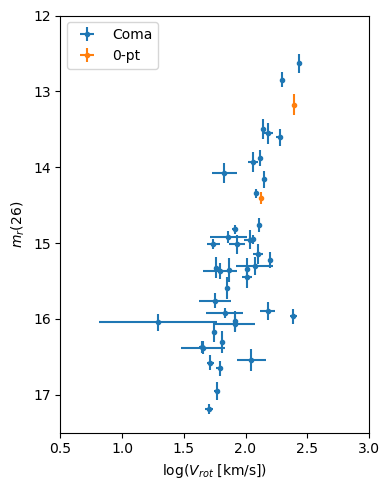

In [64]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             label='Coma')

plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             label='0-pt')

plt.xlim([0.5, 3])
plt.ylim([17.5, 12])

plt.legend()

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

# Compute the absolute magnitudes for the 0-pt calibrators based on the distance measurements

\begin{equation}
  M_r - 5\log h = m_r - \mu - 5\log h
\end{equation}
where $h$ is the reduced Hubble constant used to calibrate the distance modulus, $\mu$.

Both of our galaxies have distance moduli from Stahl et al. (2021), which *appears* to use $h = 1$.  Therefore, the distance moduli we have to use are $\mu_h = \mu - 5\log h$.

The third galaxy has a distance moduli from Pantheon+SH0ES, whose distances are based on distance ladder calibrations, so there is no assumption of $h$.

In [65]:
SGA_0pt['R_ABSMAG_SB26'] = SGA_0pt['R_MAG_SB26_CORR'] - SGA_0pt['DM1_SN'] #+ 5*np.log10(0.7)
SGA_0pt['R_ABSMAG_SB26_ERR'] = np.sqrt(SGA_0pt['R_MAG_SB26_ERR_CORR']**2 + SGA_0pt['e_DM1_SN']**2)

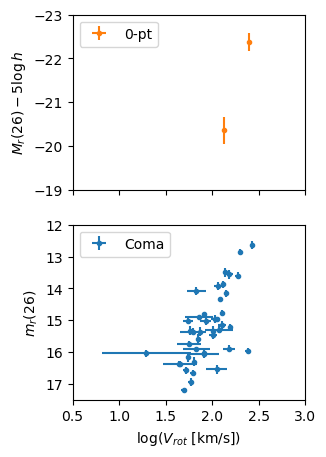

In [66]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(3,5))

ax2.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             label='Coma')

ax1.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_ABSMAG_SB26_ERR'], 
             fmt='.', 
             c='tab:orange',
             label='0-pt')

plt.xlim([0.5, 3])
ax1.set_ylim([-19, -23])
ax2.set_ylim([17.5, 12])

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.xlabel('log($V_{rot}$ [km/s])')
ax1.set_ylabel('$M_r (26) - 5\log h$')
ax2.set_ylabel('$m_r (26)$');

# Fit the TFR using the subclassed version of `hyperfit`

In [67]:
V0 = np.median(np.concatenate([np.log10(SGA_TF['V_0p33R26']), np.log10(SGA_0pt['V_0p33R26'])]))
print(V0)

1.9692043739602463


In [68]:
bounds_tfr = ((-20.0, 0.0), (0.0, 20.0), (-30.0, 0.0), (1.0e-5, 5.0))
# bounds_itfr = ((-20.0, 20.0), (0.0, 20.0), (-20.0, 0.0), (1.0e-5, 5.0))

results = hyperfit_line_multi([np.log10(SGA_TF['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                              [SGA_TF['R_MAG_SB26_CORR'], SGA_0pt['R_ABSMAG_SB26']],
                              [0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26']], 
                              [SGA_TF['R_MAG_SB26_ERR_CORR'], SGA_0pt['R_ABSMAG_SB26_ERR']], 
                              bounds_tfr, 
                              weights=[1/SGA_TF['MAX_VOL_FRAC'], 1/SGA_0pt['MAX_VOL_FRAC']]
                             )

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -68015.07697819399
     jac: array([-0.13533281, -0.19354046,  0.44383338, -0.06111804])
 message: 'Optimization terminated successfully.'
    nfev: 2335
     nit: 37
 success: True
       x: array([ -7.74226107,  15.25095552, -19.11459485,   1.05689337])
Ndim: 4 2


100%|██████████| 1000/1000 [00:03<00:00, 278.79it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.59911251 38.13320436 25.49491566 43.19410979] / 2229.9556254358527


100%|██████████| 1000/1000 [00:03<00:00, 321.89it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.15924819 39.03343554 33.76112349 53.19874246] / 2659.937123136183


100%|██████████| 1000/1000 [00:03<00:00, 318.22it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.34683268 39.64758209 37.85843952 61.87685326] / 3093.842663234928


100%|██████████| 1000/1000 [00:03<00:00, 318.67it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.63021079 43.29377773 38.36712884 54.29786881] / 2714.8934407264483


100%|██████████| 1000/1000 [00:03<00:00, 321.77it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.36466749 41.65097531 41.24888925 50.40511439] / 2520.2557193480393


100%|██████████| 1000/1000 [00:03<00:00, 319.27it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.26084129 42.82707842 46.19937928 53.97956791] / 2698.9783957324994


100%|██████████| 1000/1000 [00:03<00:00, 318.70it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.94069276 43.97502419 49.77532127 56.29643967] / 2814.821983294841


100%|██████████| 1000/1000 [00:03<00:00, 317.76it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.87141037 38.99566618 50.28072384 46.98010127] / 2593.57051843021


100%|██████████| 1000/1000 [00:03<00:00, 307.41it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.11278896 41.7794267  49.69631153 48.7865245 ] / 2655.639447978753


100%|██████████| 1000/1000 [00:03<00:00, 316.35it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.97107582 43.71356789 49.48507037 44.37711737] / 2474.2535186065948


100%|██████████| 1000/1000 [00:03<00:00, 310.25it/s]

Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [46.68457069 43.36075505 51.9620204  44.34746882] / 2598.1010200816927


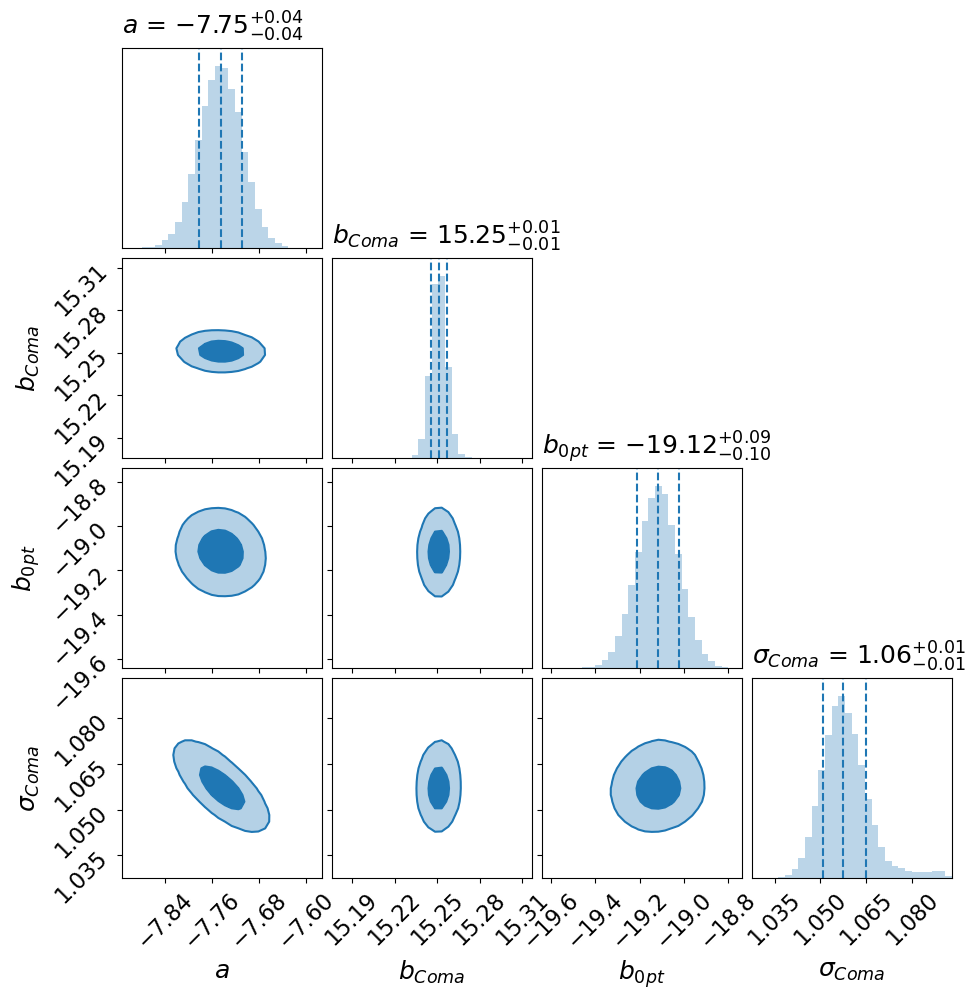

In [69]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    # range=[[-0.14, -0.117], [1.9, 2.2], [-2.55, -2.15], [0.13, 0.15]],   # Range for w0, w1, sigma. Adjust as needed.
                    # range=[[-8.4, -7.2], [15.85, 16.1], [-18.6, -17.8], [1, 1.2]], # Range for a, b, sigma.  Adjust as needed.
                    # labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    labels=['$a$', '$b_{Coma}$', '$b_{0 pt}$', r'$\sigma_{Coma}$'],
                    label_kwargs={'fontsize':18}, 
                    labelpad=0.1, 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
'''
fig.savefig('../../Figures/SV/fuji_joint_Coma_corner_20250205.png', 
            dpi=150, 
            facecolor='none', 
            bbox_inches='tight')
''';

In [70]:
print(f'           slope:  {a:.2f} +/- {np.sqrt(cov_tfr[0,0]):.3f}')
print(f'y-intercept Coma:  {b[0]:.2f} +/- {np.sqrt(cov_tfr[1,1]):.3f}')
print(f' y-intercept 0pt: {b[1]:.2f} +/- {np.sqrt(cov_tfr[2,2]):.3f}')
print(f'         scatter:   {sig_tfr[0]:.2f} +/- {np.sqrt(cov_tfr[3,3]):.3f}')

           slope:  -7.75 +/- 0.037
y-intercept Coma:  15.25 +/- 0.006
 y-intercept 0pt: -19.12 +/- 0.095
         scatter:   1.06 +/- 0.008


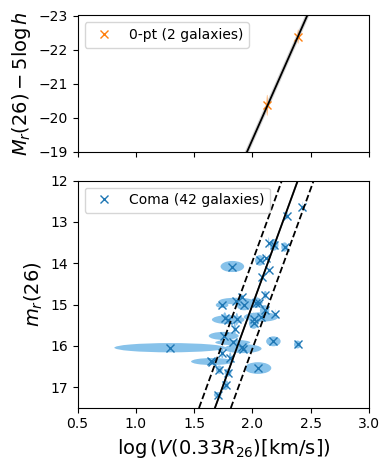

In [72]:
xvals = np.linspace(0.5, 3., 1000)
yvals = np.zeros((len(b), len(xvals)))
for i in range(len(b)):
    yvals[i] = a * (xvals - V0) + b[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain1_quantiles = np.quantile(y_chain1, [0.1587, 0.8414], axis=1)

y_chain2 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[2]
y_chain2_quantiles = np.quantile(y_chain2, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1 = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26_CORR']]
x1_err = 0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26']
y1_err = SGA_TF['R_MAG_SB26_ERR_CORR']
corr1_xy = np.zeros_like(x1_err)

data2 = [np.log10(SGA_0pt['V_0p33R26']), SGA_0pt['R_ABSMAG_SB26']]
x2_err = 0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26']
y2_err = SGA_0pt['R_ABSMAG_SB26_ERR']
corr2_xy = np.zeros_like(x2_err)
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1 = [
    Ellipse(
        xy=[data1[0][i], data1[1][i]],
        width=2*y1_err[i],
        height=2*x1_err[i],
        angle=np.rad2deg(np.arccos(corr1_xy[i])),
    )
    for i in range(len(data1[0]))
]

ells2 = [
    Ellipse(
        xy=[data2[0][i], data2[1][i]],
        width=2*y2_err[i],
        height=2*x2_err[i],
        angle=np.rad2deg(np.arccos(corr2_xy[i])),
    )
    for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 
                               figsize=(4,4.8), 
                               tight_layout=True, 
                               sharex=True, 
                               height_ratios=[3,5])

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2.fill_between(xvals, 
                 y_chain1_quantiles[0], 
                 y_chain1_quantiles[1], 
                 color="darkgray")

for i, e in enumerate(ells1):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
    
ax2.plot(data1[0], data1[1], 'x', label='Coma ({} galaxies)'.format(len(SGA_TF)))

ax2.plot(xvals, yvals[0], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals, yvals[0] - sig_tfr[0], c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals, yvals[0] + sig_tfr[0], c="k", marker="None", ls="--", lw=1.3)

ax2.set_xlabel(r"$\log{(V(0.33R_{26}) [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2.set_ylim(17.5, 12)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1.fill_between(xvals, 
                 y_chain2_quantiles[0], 
                 y_chain2_quantiles[1], 
                 color='lightgray')

for i, e in enumerate(ells2):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], 
         data2[1], 
         'x', 
         c='tab:orange',
         label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1.plot(xvals, yvals[1], c='k', marker='None', ls='-', lw=1.3)

ax1.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19, -23);
#-------------------------------------------------------------------------------
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

# Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

## Define the line perpendicular to the calibration

In [73]:
logV_n17 = (-17 - b[1])/a + V0
b_perp = -17 + (logV_n17 - V0)/a
b_perp

-16.96471124833474

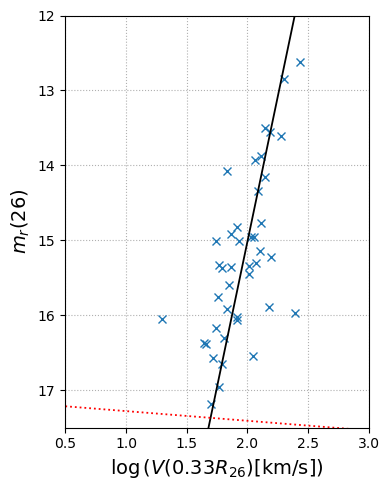

In [75]:
yvals_perp = -(xvals - V0)/a + (b_perp + b[0] - b[1])

################################################################################
# Make the plot
#-------------------------------------------------------------------------------
plt.figure(figsize=(4,5), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

plt.plot(np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26_CORR'], 'x')

plt.plot(xvals, yvals[0], c='k', marker='None', ls='-', lw=1.3)
plt.plot(xvals, yvals_perp, c='r', marker='None', ls=':', lw=1.3)

plt.xlabel(r"$\log{(V(0.33R_{26}) [\mathrm{km/s}])}$", fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.xlim(0.5, 3)
plt.ylim(17.5, 12);
################################################################################

## Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.33R_{26})) - V_0)/a + b_\perp + (b_{Coma} - b_{0pt})
\end{equation}

In [76]:
dwarfs = (SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_MAG_SB26_ERR_CORR']) > (-(np.log10(SGA_TF['V_0p33R26']) - V0)/a + b_perp + b[0] - b[1])

SGA_TF_bright = SGA_TF[~dwarfs]

print(np.sum(dwarfs))

0


Looks like we have no "dwarf" galaxies, so we don't need to repeat the calibration.

In [77]:
temp_outfile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs0_weightsVmax-1_KAD.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, V0), temp_outfile)
temp_outfile.close()

In [66]:
V0_bright = np.median(np.concatenate([np.log10(SGA_TF_bright['V_0p33R26']), np.log10(SGA_0pt['V_0p33R26'])]))
print(V0_bright)

2.0098860234777294


In [67]:
results_bright = hyperfit_line_multi([np.log10(SGA_TF_bright['V_0p33R26']) - V0_bright, np.log10(SGA_0pt['V_0p33R26']) - V0_bright], 
                                     [SGA_TF_bright['R_MAG_SB26_CORR'], SGA_0pt['R_ABSMAG_SB26']],
                                     [0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_err']/SGA_0pt['V_0p33R26']], 
                                     [SGA_TF_bright['R_MAG_SB26_ERR_CORR'], SGA_0pt['R_ABSMAG_SB26_err']], 
                                     bounds_tfr)

a_bright, b_bright, sig_tfr_bright, cov_tfr_bright, tfr_mcmc_samples_bright, hf_tfr_bright = results_bright

     fun: -2297.9647547841896
     jac: array([-0.00895852,  0.00331966,  0.00104592,  0.00022737])
 message: 'Optimization terminated successfully.'
    nfev: 2920
     nit: 47
 success: True
       x: array([ -7.81074665,  15.2722892 , -19.07411069,   1.08574613])
Ndim: 4 2


100%|██████████| 1000/1000 [00:01<00:00, 655.63it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.81154382 33.06429416 35.0991175  37.35707397] / 2140.5771910583017


100%|██████████| 1000/1000 [00:01<00:00, 637.97it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.58362182 37.95431419 50.78964987 48.42255262] / 2539.482493306485


100%|██████████| 1000/1000 [00:01<00:00, 648.32it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.96346431 41.11628946 47.48134406 49.9364276 ] / 2496.8213801138954


100%|██████████| 1000/1000 [00:01<00:00, 627.73it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.57702069 37.12400086 41.38798885 55.75610417] / 2787.8052085619706


100%|██████████| 1000/1000 [00:01<00:00, 616.53it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [45.39798252 46.37165449 44.93730428 51.46554852] / 2573.277425841678


100%|██████████| 1000/1000 [00:01<00:00, 640.21it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.16568379 47.23267708 45.91013372 64.53941341] / 3226.970670324159


100%|██████████| 1000/1000 [00:01<00:00, 632.35it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [58.39905085 43.35981656 44.30510061 65.27165455] / 3263.582727439076


100%|██████████| 1000/1000 [00:01<00:00, 640.19it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.62947353 40.25066823 46.24694256 62.67586412] / 3133.793206010311


100%|██████████| 1000/1000 [00:01<00:00, 611.34it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.29336473 41.81421642 49.2276762  63.05949307] / 3152.974653524113


100%|██████████| 1000/1000 [00:01<00:00, 582.42it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [54.26434671 42.62577693 50.37092137 61.72133108] / 3086.066553995742


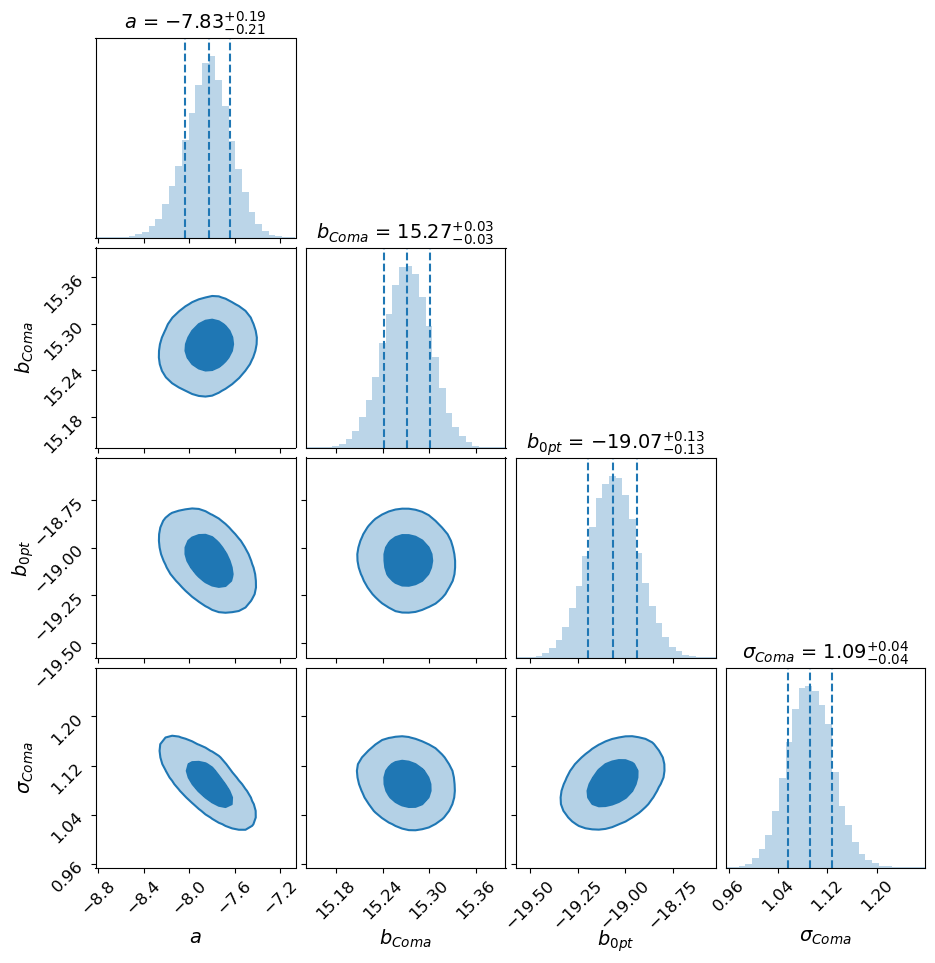

In [68]:
fig = corner.corner(tfr_mcmc_samples_bright.T, bins=30, smooth=1,
                    # range=[[-8.2, -6.8], [15.5, 15.75], [-19.2, -18.25], [0.95, 1.2]],
                    labels=['$a$', '$b_{Coma}$', '$b_{0pt}$', r'$\sigma_{Coma}$'],
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title = {'Joint fit of Coma and 0-pt calibrators'},
                    title_kwargs={"fontsize": 14})

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.get_label().set_fontsize(14)
    ax.yaxis.get_label().set_fontsize(14)

# fig.savefig('../../Figures/SV/fuji_Coma_corner_20240130.png', dpi=150)

In [69]:
print(f'           slope: {a_bright:.2f}  +/- {np.sqrt(cov_tfr_bright[0,0]):.2f}')
print(f'y-intercept Coma:  {b_bright[0]:.2f} +/- {np.sqrt(cov_tfr_bright[1,1]):.2f}')
print(f' y-intercept 0pt: {b_bright[1]:.2f} +/- {np.sqrt(cov_tfr_bright[2,2]):.2f}')

           slope: -7.83  +/- 0.20
y-intercept Coma:  15.27 +/- 0.03
 y-intercept 0pt: -19.07 +/- 0.13


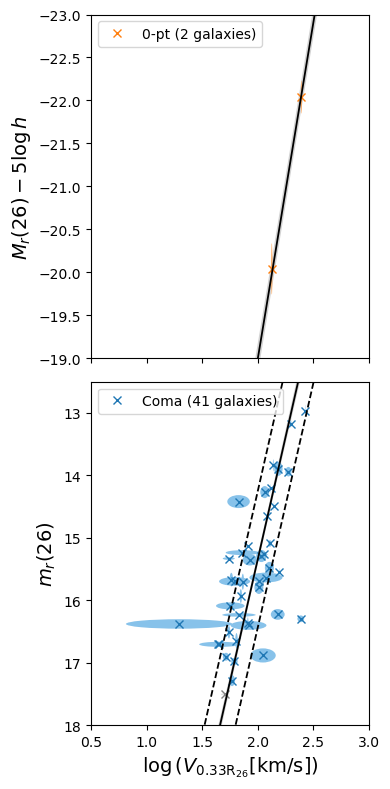

In [70]:
yvals_bright = np.zeros((len(b_bright), len(xvals)))
for i in range(len(b_bright)):
    yvals_bright[i] = a_bright * (xvals - V0_bright) + b_bright[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1_bright = np.outer(xvals - V0_bright, 
                           tfr_mcmc_samples_bright[0]) + tfr_mcmc_samples_bright[1]
y_chain1_bright_quantiles = np.quantile(y_chain1_bright, [0.1587, 0.8414], axis=1)

y_chain2_bright = np.outer(xvals - V0_bright, 
                           tfr_mcmc_samples_bright[0]) + tfr_mcmc_samples_bright[2]
y_chain2_bright_quantiles = np.quantile(y_chain2_bright, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1_bright = [np.log10(SGA_TF_bright['V_0p33R26']), SGA_TF_bright['R_MAG_SB26_CORR']]
x1_bright_err = 0.434*SGA_TF_bright['V_0p33R26_err']/SGA_TF_bright['V_0p33R26']
y1_bright_err = SGA_TF_bright['R_MAG_SB26_ERR_CORR']
corr1_xy_bright = np.zeros_like(x1_bright_err)

# Removed galaxies
data1_removed = [np.log10(SGA_TF['V_0p33R26'][dwarfs]), SGA_TF['R_MAG_SB26_CORR'][dwarfs]]
x1_err_removed = 0.434*SGA_TF['V_0p33R26_err'][dwarfs]/SGA_TF['V_0p33R26'][dwarfs]
y1_err_removed = SGA_TF['R_MAG_SB26_ERR_CORR'][dwarfs]
corr1_xy_removed = np.zeros_like(x1_err_removed)

# data2 is the same as the first fit
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1_bright = [
                Ellipse(
                    xy=[data1_bright[0][i], data1_bright[1][i]],
                    width=2*y1_bright_err[i],
                    height=2*x1_bright_err[i],
                    angle=np.rad2deg(np.arccos(corr1_xy_bright[i])),
                )
                for i in range(len(data1_bright[0]))
]

ells1_removed = [
                 Ellipse(
                     xy=[data1_removed[0][i], data1_removed[1][i]], 
                     width=2*y1_err_removed[i], 
                     height=2*x1_err_removed[i], 
                     angle=np.rad2deg(np.arccos(corr1_xy_removed[i])), 
                 )
    for i in range(len(data1_removed[0]))
]

# ells2 is the same as the first fit, but matplotlib won't let us reuse it
ells2_bright = [
                Ellipse(
                    xy=[data2[0][i], data2[1][i]],
                    width=2*y2_err[i],
                    height=2*x2_err[i],
                    angle=np.rad2deg(np.arccos(corr2_xy[i])),
                )
                for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 
                               figsize=(4,8), 
                               tight_layout=True, 
                               sharex=True)

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2.fill_between(xvals, 
                 y_chain1_bright_quantiles[0], 
                 y_chain1_bright_quantiles[1], 
                 color="lightgray")

for i, e in enumerate(ells1_bright):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
for i, e in enumerate(ells1_removed):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('gray', amount=1.75))
    
ax2.plot(data1_bright[0], data1_bright[1], 'x', 
         label='Coma ({} galaxies)'.format(len(SGA_TF_bright)))
ax2.plot(data1_removed[0], data1_removed[1], 'x', c='gray')

ax2.plot(xvals, yvals_bright[0], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals, yvals_bright[0] - sig_tfr_bright[0], 
         c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals, yvals_bright[0] + sig_tfr_bright[0], 
         c="k", marker="None", ls="--", lw=1.3)

ax2.set_xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2.set_ylim(18, 12.5)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1.fill_between(xvals, 
                 y_chain2_bright_quantiles[0], 
                 y_chain2_bright_quantiles[1], 
                 color='lightgray')

for i, e in enumerate(ells2_bright):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], 
         data2[1], 
         'x', 
         c='tab:orange',
         label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1.plot(xvals, yvals_bright[1], c='k', marker='None', ls='-', lw=1.3)

ax1.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19, -23);
#-------------------------------------------------------------------------------
################################################################################

## Define the line perpendicular to the calibration

In [71]:
logV_n17_bright = (-17 - b_bright[1])/a_bright + V0_bright
b_perp_bright = -17 + (logV_n17_bright - V0_bright)/a_bright
b_perp_bright

-16.96632211216839

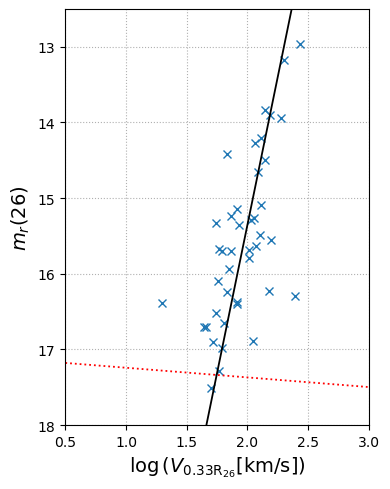

In [72]:
yvals_perp_bright = -(xvals - V0_bright)/a_bright + (b_perp_bright + b_bright[0] - b_bright[1])

################################################################################
# Make the plot
#-------------------------------------------------------------------------------
plt.figure(figsize=(4,5), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

plt.plot(np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26_CORR'], 'x')

plt.plot(xvals, yvals_bright[0], c='k', marker='None', ls='-', lw=1.3)
plt.plot(xvals, yvals_perp_bright, c='r', marker='None', ls=':', lw=1.3)

plt.xlabel(r"$\log{(V_\mathrm{0.33R_{26}} [\mathrm{km/s}])}$", fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.xlim(0.5, 3)
plt.ylim(18, 12.5);
################################################################################

## Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.33R_{26})) - V_0)/a + b_\perp + (b_{Coma} - b_{0pt})
\end{equation}

In [73]:
dwarfs2 = (SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_MAG_SB26_ERR_CORR']) > (-(np.log10(SGA_TF['V_0p33R26']) - V0_bright)/a_bright + b_perp_bright + b_bright[0] - b_bright[1])

SGA_TF_bright2 = SGA_TF[~dwarfs2]

print(np.sum(dwarfs2))

1


Looks like we still have 1 "dwarf" galaxy, so we can stop here.

In [74]:
temp_outfile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs1_KAD.pickle', 'wb')
pickle.dump((cov_tfr_bright, tfr_mcmc_samples_bright, V0_bright), temp_outfile)
temp_outfile.close()